In [135]:
import pandas as pd
import pandas as pd
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from xDL.utils.data_utils import *

In [136]:
import sys
sys.path.append('..')
from xDL.models.NATT import NATT

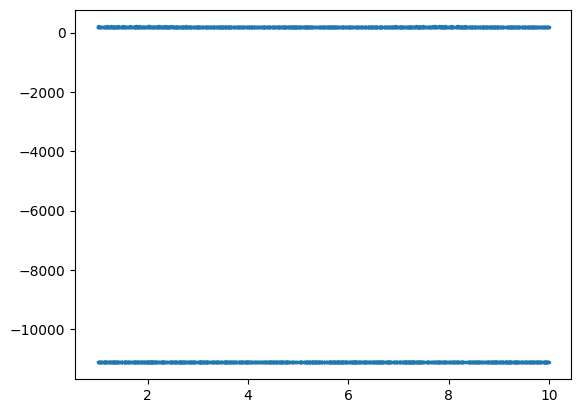

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(202)

# Number of data points
num_samples = 5000

# Define a list of possible categorical values
categories = ['A', 'B']

# Generate random categorical data as an array of strings
categorical1 = np.random.choice(categories, size=num_samples)

categories = ['Yes', 'No', 'Maybe']
categorical2 = np.random.choice(categories, size=num_samples)

# Generate the input variable X as a random draw from a linspace
X1 = np.random.uniform(1, 10, size=num_samples)
X2 = np.random.uniform(2, 4, size=num_samples)

# Generate continuous variables as a function of X with noise dependent on X
def func1(x):
    return 5*np.sin(x) / 5 

def func2(x):
    return -(2*(x-3))**2 / 5


# Create mappings for categorical values
category_map1 = {'A': 200.0, 'B': -11111}
category_map2 = {'Yes': 0.0, 'No': -0.5, 'Maybe': 0.5}

# Calculate y by combining continuous and categorical functions
#
y = func1(X1) - func2(X2)  + np.vectorize(category_map1.get)(categorical1) + np.vectorize(category_map2.get)(categorical2) + np.random.normal(0, 0.3, size=num_samples) 


data = pd.DataFrame({"Target": y, 'Category1': categorical1, 'Category2': categorical2, 'Continuous1':X1, 'Continuous2':X2})


plt.scatter(X1, y, s=2)


In [138]:
model = NATT(
    "Target ~  -1 + MLP(Continuous1) +  MLP(Continuous2) + Transformer(Category1):Transformer(Category2)", 
    data=data, 
    feature_dropout=0.0001,
    out_activation="linear",
    ff_dropout=0.1, 
    dropout=0.1,
    attn_dropout=0.1,
    batch_size=2048
    )
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(), "importances": None, "att_weights": None},
    metrics= {"output": ["mse", "mae"], "importances": None, "att_weights": None},)
history = model.fit(
    model.training_dataset, 
    epochs=50, 
    validation_data=model.validation_dataset,
    verbose=1,
)

Epoch 1/50
(None, 3, 32)
(None, 3, 32)
2/2 [==============================] - 10s 977ms/step - loss: 61651356.0000 - output_loss: 61651356.0000 - output_mse: 61651356.0000 - output_mae: 5647.3232 - val_loss: 60507916.0000 - val_output_loss: 60507916.0000 - val_output_mse: 60507916.0000 - val_output_mae: 5546.3730
Epoch 2/50
2/2 [==============================] - 1s 435ms/step - loss: 62112160.0000 - output_loss: 62112160.0000 - output_mse: 62112160.0000 - output_mae: 5688.2363 - val_loss: 62850864.0000 - val_output_loss: 62850864.0000 - val_output_mse: 62850864.0000 - val_output_mae: 5753.6968
Epoch 3/50
2/2 [==============================] - 1s 489ms/step - loss: 61678288.0000 - output_loss: 61678288.0000 - output_mse: 61678288.0000 - output_mae: 5650.0449 - val_loss: 58654232.0000 - val_output_loss: 58654232.0000 - val_output_mse: 58654232.0000 - val_output_mae: 5382.7842
Epoch 4/50
2/2 [==============================] - 1s 345ms/step - loss: 61737952.0000 - output_loss: 61737952.000

In [139]:
dataset = model.data.copy()
dataset["Category1"] = np.repeat("Unknown", len(dataset))
dataset["Category2"] = np.repeat("Unknown", len(dataset))
dataset["Continuous1"] = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(dataset))
dataset["Continuous2"] = np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), len(dataset))
dataset = df_to_dataset(
            dataset,
            model.data,
            model.input_dict,
            model.y,
            batch_size=1024,
            shuffle=False,
            feature_information=model.feature_information,
            task=model.binning_task,
)

In [140]:
model.trainable = False
assert model.encoder.trainable == False  # All layers in `model` are now frozen
assert model.feature_nets[1].layers[0].trainable == False  # `trainable` is propagated recursively


In [141]:
output = model.predict(dataset, verbose=1)
expl = output["importances"]
expl

(None, 3, 32)
5/5 [==============================] - 1s 55ms/step


array([[0.30211598, 0.353949  , 0.343935  ],
       [0.30211598, 0.353949  , 0.343935  ],
       [0.30211598, 0.353949  , 0.343935  ],
       ...,
       [0.30211598, 0.353949  , 0.343935  ],
       [0.30211598, 0.353949  , 0.343935  ],
       [0.30211598, 0.353949  , 0.343935  ]], dtype=float32)

In [142]:
x = output["output"]
x

array([[-467.50262],
       [-467.37518],
       [-467.24786],
       ...,
       [-434.1536 ],
       [-434.26993],
       [-434.3863 ]], dtype=float32)